# Assignment 3 - Emergent Communication and Abstractions?

In this assignment we are going to explore the field of Emergent Communication and see how it situates within Cognitive Science as a tool to explain how language is shaped and evolves.

We will first explore how emergent communication works and how two agents can interact with each other to collaboratively solve a task via communicating together. We will then explore how the mechanism of abstractions learning can be used in tandem with emergent communication to obtain results that mimic how humans tend towards concisiveness while playing a collaborative game over repeated interactions.


# Part 1: Emergent Communication (5 points)

Emergent Communication is an area of research within Deep Learning. It studies how populations of agents (in ours and many other cases 2 agents) develop language in order to solve cooperative tasks. Motivations for study in this area include deriving better algorithms for enabling inter-agent cooperation through communication and understanding why human languages have the qualities which they do. This is usually studied within Lewis signalling games, which we will introduce now.

![A Lewis signalling game example.](https://robertodessi.github.io/images/focus.png)

A lewis signalling game is a 2-player cooperative game. The two agents are referred to as the speaker and the listener. The speaker receives an observation (e.g. image, feature vector, etc.) and constructs a message which is communicated to the listener. The listener receives the message and a set of observations. One of these observations is the one that the speaker observed. Using the message and the observation, the listener selects the observation which they think is the best match.

The emergent communication part of this assignment will proceed as follows:
1) Program a Q-learning algorithm which will be used by both the speaker and the listener
2) Train and evaluate the agents on a simple dataset


## Define Q-Learning for Speaker and Listener

In Emergent Communication, our models for both agents are usually neural networks. This is because neural networks allow for great generalization and have a bias for simplicity, making them really helpful at analyzing language evolution. Here instead, to keep things simple, we will use tabular Q-learning for our agents like in Assignment 1. Differently from Assignment 1, we now have 2 (!) agents.

This means we will have 2 Q-tables, one that our first agent (the speaker) will use to choose the word to communicate given the observation, and one that our second agent (the listener) will use to choose what action to pick given the word the speaker communicates to them.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
"Some useful functions"

def reward_function(actual, guess):
    return int(actual == guess)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def visualise_policies(speaker, listener, num_concepts, preamble = ''):
    if preamble:
        print(preamble)
    for c in range(num_concepts):
        message = speaker.sample_action(c, test=True)
        action = listener.sample_action(message, test=True)
        reward = reward_function(c, action)
        print('Concept: %i, Message: %i, Action: %i, Reward: %i'%(c, message, action, reward))

Instantiate two Q-tables, one for the Speaker and one for the Listener. Make sure that the Speaker maps from concepts to messages and the listener from messages to concepts.

We will start by having 5 concepts and 5 messages, so the Speaker will try to instruct the Listener about 5 different objects. Note that in Emergent Communication usually the episode lasts only one step, so the Q-learning update is simpler than usual (called myopic). The update thus does not involve estimating future rewards. You can achieve that by just simplifying the Q-learning update rule with $\gamma = 0$.

<!-- ![text](algorithm.png) -->
[![Q-learning algorithm](https://miro.medium.com/v2/resize:fit:1400/1*7AWfjw8YDfoRqnIO71DjiA.png)](https://en.wikipedia.org/wiki/Q-learning)

In [ ]:
"Your code here"
# PARAMETERS
lr = 0.9 # Learning rate
num_concepts = 5 # Number of possible information that we want to communicate
num_messages = 5 # Number of possible ways to communicate the information
n_iterations = 100000 # Iteration to train for

# Class representing a Q-Table
# It contains a matrix of NxM mapping the N states to M actions
# For the speaker, it maps N concepts to M messages
# For the listener, it maps N messages to M concepts
class Q_Table():
  def __init__(self, n, m):
    self.state_size = n
    self.action_size = m
    self.table = np.zeros((n, m))

  # Sampling an optimal action for the input state
  def sample_action(self, state_idx, test = True):
    return np.argmax(self.table[state_idx])

# Applying the greedy policy
# In this policy, we choose the action which Q-value is the highest for the given state and goal
def greedy_policy(Qtable, state_idx):
  # Argument of the maximum value of the Q-Table = optimal action
  action = np.argmax(Qtable[state_idx])
  return int(action)

# Applying the epsilon-greedy policy
# In this policy, we receive an epsilon value that will determine the propbability of our system to choose a random action instead of applying the greedy strategy.
def epsilon_greedy_policy(Qtable, state_idx, epsilon, action_space_size):
  # Draw a random real between 0 and 1, if it is smaller than epsilon, apply the random policy, otherwise, choose the greedy policy
  return random_policy(action_space_size) if random.uniform(0, 1) < epsilon else greedy_policy(Qtable, state_idx)

# Applying the random policy
def random_policy(action_space_size):
  # We select a random action out of the action space
  return np.random.randint(0, action_space_size)

In [ ]:
# Base epsilon value, to be decayed over time
epsilon_0 = 1.0

def build_epsilons(rate = 0.001):
  # Set of epsilon values decaying with a linear function
  epsilon = np.zeros(n_iterations)

  # We vary the values of epsilon throughout the total number of episodes
  # We use the ratio of the current episode by the total number to keep an adpatative formula for different values of n_training_episodes
  for episode in range(n_iterations):
    epsilon[episode] = max(0.01, epsilon_0 * (1 - np.power(episode/n_iterations, 3)))

  return epsilon, np.zeros(n_iterations)

epsilon, greedy = build_epsilons()

Polciies after training
Concept: 0, Message: 4, Action: 0, Reward: 1
Concept: 1, Message: 1, Action: 1, Reward: 1
Concept: 2, Message: 3, Action: 2, Reward: 1
Concept: 3, Message: 2, Action: 3, Reward: 1
Concept: 4, Message: 0, Action: 4, Reward: 1


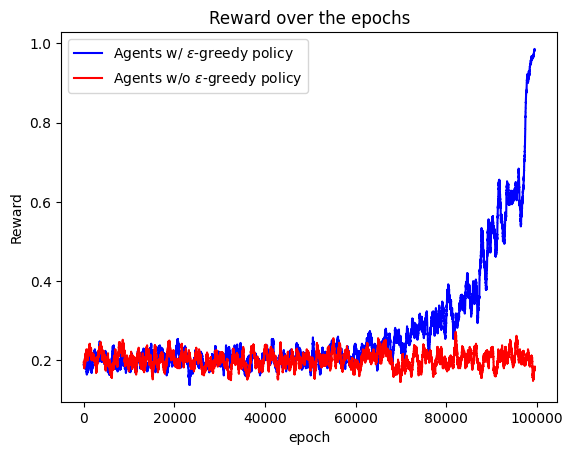

In [ ]:
# Repartition of initial concepts picked
repart = np.zeros(num_concepts)

# Training loop for the speaker/listener system
# At every iteration, we map from a concept to a message for the speaker
# and then, from the same message to a resulting concept for the listener
# The goal is to obtain the same concepts at the beginning and the end
def train(speaker, listener, epsilons, update = True, lr_speaker = lr, lr_listener = lr):
  # List of rewards over the iterations
  rew_list = []
  for epoch in range(len(epsilons)):
    # We sample a random concept from the state space
    concept = np.random.randint(0, num_concepts)
    # We get the message corresponding to the given concept from an epsilon greedy policy with a linear decay
    # The mapping is done with the speaker's Q-Table
    message = epsilon_greedy_policy(speaker.table, concept, epsilons[epoch], num_messages)
    # We remap the message to a concept with the same epsilon greedy policy
    # This time, the mapping is realised with the listener's Q-Table
    action = epsilon_greedy_policy(listener.table, message, epsilons[epoch], num_concepts)
    # We compute the epoch's reward with the starting and ending concepts
    reward = reward_function(concept, action)
    if update:
      "Updates"
      # After the epoch we need to update both the speaker's and listener's Q-Tables with the obtained reward
      speaker.table[concept][message] += lr_speaker * (reward - speaker.table[concept][message]) #speaker
      listener.table[message][concept] += lr_listener * (reward - listener.table[message][concept]) #listener
    rew_list.append(reward)
    repart[concept] += 1
  return rew_list

# Speaker
speaker = Q_Table(num_concepts, num_messages)
# Listener
listener = Q_Table(num_messages, num_concepts)
# Train with epsilon greedy policy
rew_list = train(speaker, listener, epsilon)

# Speaker
speaker_greedy = Q_Table(num_concepts, num_messages)
# Listener
listener_greedy = Q_Table(num_messages, num_concepts)
# Train without epsilon greedy policy
rew_list_greedy = train(speaker_greedy, listener_greedy, greedy)

# Plotting the results
plt.plot(moving_average(rew_list, 500), label=r'Agents w/ $\epsilon$-greedy policy', color='blue')
plt.plot(moving_average(rew_list_greedy, 500), label=r'Agents w/o $\epsilon$-greedy policy', color='red')
plt.title('Reward over the epochs')
plt.xlabel('epoch')
plt.ylabel('Reward')
plt.legend()

# To evaluate the resulting policies, we run 1000 episodes on the resulting Q-tables
eg_perf = train(speaker, listener, np.zeros(1000), False)
g_perf = train(speaker_greedy, listener_greedy, np.zeros(1000), False)

visualise_policies(speaker, listener, num_concepts, preamble='Polciies after training')

Complete the training loop. Make sure to update both the speaker and the listener. Usually the learning rate is the same but good reasons can be made to do it differently.

Comment here what choices you ended up taking to make communication converge to a good reward:

Your answer: In order to converge to a good reward, it was necessary to implement some exploration for our two agents. Without this, they wouldn't discover the proper actions to perform to get a reward.

Applying an epsilon greedy policy with a linear decay allowed our agents to reach a perfect mapping of concepts most of the time.

However, even if the mapping is most of the time perfect, it sometimes mismaps one of the concepts in either the speaker or listener. We can try to investigate on this issue.

In [135]:
perfs = []

for _ in range(10):
  # Reset the Q-Table
  speaker = Q_Table(num_concepts, num_messages)
  listener = Q_Table(num_messages, num_concepts)
  # Train with epsilon greedy policy
  rew_list = train(speaker, listener, epsilon, lr_speaker=0.9, lr_listener=0.8)
  # Test the resulting policies over 1000 epochs
  perf = train(speaker, listener, np.zeros(1000), update=False)
  # Average performance for this try
  perfs.append(sum(perf)/len(perf))

# If average != 1, then we do not always reach a perfectly mapped communication
print(f'Average score: {sum(perfs)/len(perfs)}')

Average score: 0.8187000000000001


Since we have 2 different Q-Tables training simultenaously, maybe we could try and experiment with their learning rate, and even dissociate them. (This ended up being irrelevant to reaching an optimal policy but I decided to let it here because I thought it was still worth mentionning)

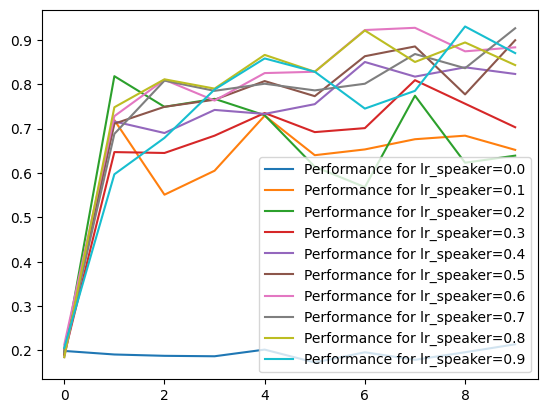

In [ ]:
all_perfs = []

for i in range(10):
  lr_perfs = []
  for j in range(10):
    # Let's test training result multiple times to see if we always manage to find an perfect policy
    eg_perf = []
    for _ in range(10):
      # Reset the Q-Table
      speaker = Q_Table(num_concepts, num_messages)
      listener = Q_Table(num_messages, num_concepts)
      # Train with epsilon greedy policy
      rew_list = train(speaker, listener, epsilon, lr_speaker=lr*(j/10), lr_listener = lr*(i/10))
      # Test the resulting policies over 100 epochs
      perf = train(speaker, listener, np.zeros(100), update=False)
      # Average performance for this try
      eg_perf.append(sum(perf)/len(perf))

    lr_perfs.append(sum(eg_perf)/len(eg_perf))
  all_perfs.append(lr_perfs)

# Average of averages of perf...
# print(f'Avg: {sum(eg_perf)/len(eg_perf)}')

for i in range(10):
  plt.plot(all_perfs[i], label=f'Performance for lr_speaker={i/10}')

plt.legend()

In [ ]:
for i in range(len(all_perfs)):
  print(f'lr_speaker = {i/10}: optimal lr_listener = {(np.argmax(all_perfs[i]))/10} ({max(all_perfs[i])})')

lr_speaker = 0.0: optimal lr_listener = 0.9 (0.21400000000000002)
lr_speaker = 0.1: optimal lr_listener = 0.4 (0.7290000000000001)
lr_speaker = 0.2: optimal lr_listener = 0.1 (0.8180000000000002)
lr_speaker = 0.3: optimal lr_listener = 0.7 (0.8089999999999999)
lr_speaker = 0.4: optimal lr_listener = 0.6 (0.8499999999999999)
lr_speaker = 0.5: optimal lr_listener = 0.9 (0.8989999999999998)
lr_speaker = 0.6: optimal lr_listener = 0.7 (0.9269999999999999)
lr_speaker = 0.7: optimal lr_listener = 0.9 (0.9259999999999999)
lr_speaker = 0.8: optimal lr_listener = 0.6 (0.921)
lr_speaker = 0.9: optimal lr_listener = 0.8 (0.93)


The best performing system ended up being the one that uses a speaker learning rate of 0.9 and a listener learning rate of 0.8. However, even if it brings a slight improvement, this was not enough to conctantly bring our system to a optimal policy after training.

If the design of the algorithm is correct, the problem might be a lack of training. The next thing we can try is to augment the number of iterations of the training process.

In [137]:
n_iterations = 1000000
epsilon, greedy = build_epsilons()

perfs = []

for _ in range(10):
  # Reset the Q-Table
  speaker = Q_Table(num_concepts, num_messages)
  listener = Q_Table(num_messages, num_concepts)
  # Train with epsilon greedy policy
  rew_list = train(speaker, listener, epsilon, lr_speaker=0.9, lr_listener=0.8)
  # Test the resulting policies over 1000 epochs
  perf = train(speaker, listener, np.zeros(1000), update=False)
  # Average performance for this try
  perfs.append(sum(perf)/len(perf))

# If average != 1, then we do not always reach a perfectly mapped communication
print(f'Average score: {sum(perfs)/len(perfs)}')

Average score: 0.9359


We can see that with more training, we are able to reach an optimal mapping more frequently, as suggest the higher score. Therefore, if we want to reach optimal mappings 100% of the time, we might need to perform a stronger training process.

## Part 2: Pancake stacks, a more complex dataset (5 points)

We are going to consider a simplification of the tower-building environment that is presented in McCarthy (https://arxiv.org/pdf/2107.00077). Instead, we are going to consider an agent that creates pancake stacks.

The environment is a simplification of the one of Assignment 1: instead of receiving reward only at the end of the episode, the speaker and listener get rewarded at each step for getting the ingredients right or wrong.

You can imagine it as if the speaker is able to see  at each step what ingredient the listener uses and can tell them if they are doing the right or wrong thing, meanwhile the speaker itself can implicitly reward itself for picking the word that made the listener pick the right action.

In [ ]:
import random

class Dataset:

    def __init__(self):
        self.sequences = []

    def add_sequence(self, seq):
        self.sequences.append(seq)

    def get_dataset(self):
        return self.sequences

    def get_average_length(self):
        lengths = [len(s) for s in self.sequences]
        return sum(lengths)/len(lengths)

    def rewrite(self, old_subseq, new_subseq):
        total_reductions = 0
        for seq in self.sequences:
            n = len(old_subseq)
            for i in range(len(seq) - n + 1):
                if seq[i:i+n] == old_subseq:
                    seq[i:i+n] = new_subseq
                    total_reductions += 1
        return total_reductions


def my_dataset():
    recipes = Dataset()
    recipes.add_sequence([0,1,2,0,1,2])
    recipes.add_sequence([0,1,1,0,1,1])
    recipes.add_sequence([0,1,1,0,2])
    recipes.add_sequence([0,2,0,2,0,2])
    recipes.add_sequence([0,1,1,1,1,1])
    recipes.add_sequence([0,2,2,2,2,2])
    recipes.num_ingredients = 3
    return recipes

recipes = my_dataset()

# An example of a rewrite.
#recipes.rewrite([1,1],[3])
#recipes.sequences

def sample_goal(dataset):
     return random.choice(dataset)



First of all, we try a normal communication game where the speaker samples a recipe, and tries to communicate step by step to the listener, who has to recreate the pancake the speaker intended to communicate.

Before training loop
Concept: 0, Message: 0, Action: 0, Reward: 1
Concept: 1, Message: 0, Action: 0, Reward: 0
Concept: 2, Message: 0, Action: 0, Reward: 0
After training loop
Concept: 0, Message: 1, Action: 0, Reward: 1
Concept: 1, Message: 4, Action: 1, Reward: 1
Concept: 2, Message: 0, Action: 2, Reward: 1


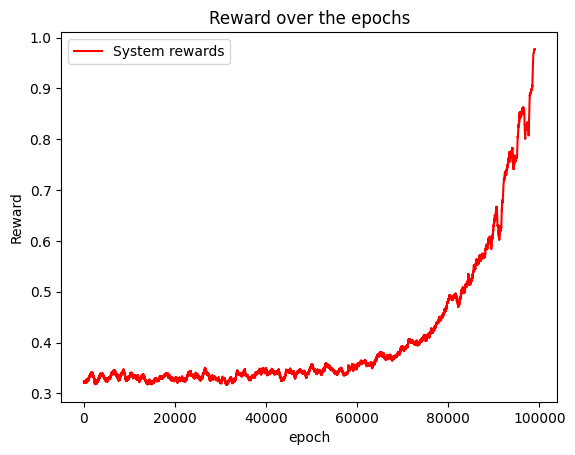

In [ ]:
# Dataset
recipes = my_dataset()

# Parameters
num_concepts = 3 # Maximum number of ingredients and abstractions
num_messages = 5 # Maximum number of messages
n_iterations = 100000

# Speaker
speaker = Q_Table(num_concepts, num_messages)
# Listener
listener = Q_Table(num_messages, num_concepts)

# Training loop for the pancake scenario
# It is basically moslty similar to the previous scenario,
# except now, the goal is to communicate a list of concepts instead of just one
# The goal is to get the whole list of concepts right
def train_pancakes(speaker, listener, epsilons, update = True):
  # Training
  rew_list = []
  dataset = recipes.get_dataset()
  visualise_policies(speaker, listener, num_concepts, preamble='Before training loop')
  for epoch in range(n_iterations):
      goal = sample_goal(dataset) # Sample a recipe from the dataset
      ep_rewards = 0
      for concept in goal:
          message = epsilon_greedy_policy(speaker.table, concept, epsilons[epoch], num_messages)
          action = epsilon_greedy_policy(listener.table, message, epsilons[epoch], num_concepts)
          reward = reward_function(concept, action)
          if update:
            "Updates"
            speaker.table[concept][message] += lr * (reward - speaker.table[concept][message]) #speaker
            listener.table[message][concept] += lr * (reward - listener.table[message][concept]) #listener
          ep_rewards += reward
      rew_list.append(ep_rewards/len(goal))
  return rew_list

lin_epsilon, _ = build_epsilons()
rew_list = train_pancakes(speaker, listener, lin_epsilon)

visualise_policies(speaker, listener, num_concepts, preamble='After training loop')

plt.plot(moving_average(rew_list, 1000), label=r'System rewards', color='red')
plt.title('Reward over the epochs')
plt.xlabel('epoch')
plt.ylabel('Reward')
plt.legend()

In [ ]:
print(f'Average utterance length after training: {recipes.get_average_length()}')

Average utterance length after training: 5.833333333333333


Hopefully communication works! If we consider the length of an utterance, here defined as the whole sentence needed to describe a full scene (a goal pancake), you can easily count how long a round of communication is on average.

Your answer:

$\frac{\sum_{goal_i}len(goal_i)}{n_{goals}} \approx 5.833$

In the McCarthy paper above, it is shown that humans tend to more concise utterances the more they collaborate on the task. This is achieved through the introduction of abstractions.

In our case an abstraction might look like "a double stack of bacon" or "two bacon stripes with sauce in between". Whatever appears frequently in the dataset is more likely to be "abstracted" into a concept carrying more information!

Thus, we will introduce a mechanism of introducing abstractions in Emergent Communication, to obtain a two-agents system that show the same tendencies as the ones in humans from the McCarthy paper linked above.


We will intertwine the communication with an Abstraction phase, where the Speaker can revise their experience and find the most common subsequence. It can then introduce a new concept (macro-ingredient in our case): an abstraction!

In [ ]:
def find_abstractions(dataset):
    "We want to find the most common subsequences in the dataset"
    all_subsequences = {}
    for seq in dataset:
        "Your code: count the frequency of all subsequences of all lengths"
        # We iterate over all the concepts in the sequence
        for i in range(len(seq) - 1):
          # Then we iterate over all the possible subsequences starting from the current concept
          for j in range(2, len(seq) + i):
            subseq = seq[i:j]
            # If the subsequence was not met before, we create a counter for it
            if subseq not in list(all_subsequences.keys()):
              all_subsequences[tuple(subseq)] = 1
            # otherwise, we increment the existing counter
            else:
              all_subsequences[tuple(subseq)] += 1
    "Your code: return the most common subsequence, if there are ties, return one of them at random"
    # In the end, the most common subsequence is the one whose counter is the highest
    max_subseq = max(all_subsequences, key = all_subsequences.get)
    return list(max_subseq) #e.g. if you find [1,1] to be the most common subsequence, return [1,1]

print(find_abstractions(recipes.sequences))

[0, 1]


After listing all subsequences in our current dataset, we were able to identify [0, 1] as the most common subsequence of concepts. Creating an astraction to shorten this subsequence could potentially make us reduce the average length of utterance.

In [ ]:
# Dataset
recipes = my_dataset()

# Parameters
"We will use 2 Q-learning agents again"
num_concepts = 8 # Maximum number of ingredients and abstractions (at first, the q-values at the abstraction indexes will not have a meaning but as soon we introduce a new abstraction, one more will)
num_messages = 8 # Maximum number of messages (one per concept we want to communicate)

# Speaker
speaker = Q_Table(num_concepts, num_messages)
# Listener
listener = Q_Table(num_messages, num_concepts)
# Epsilon decay
lin_epsilon, _ = build_epsilons()

"The number of abstractions phases we will do, i.e. how many times we will find an abstraction"
n_abstractions = 5

starting_concepts = recipes.num_ingredients

# New training loop, this time introducing abstraction after every training
# and comparing the results as the abstraction level gets highrr
def train_pancakes_abstractions(speaker, listener, epsilons, update = True):
  # Training
  rew_list = []
  # We track the lengths of utterances after every abstraction step to monitor the abstraction efficiency
  utterance_length_list = []
  for step in range(n_abstractions):
      dataset = recipes.get_dataset()
      utterance_length_list.append(recipes.get_average_length())
      for epoch in range(len(epsilons)):
          goal = sample_goal(dataset) #Sample a recipe from the dataset
          ep_rewards = 0
          for concept in goal:
              message = epsilon_greedy_policy(speaker.table, concept, epsilons[epoch], num_messages)
              action = epsilon_greedy_policy(listener.table, message, epsilons[epoch], num_concepts)
              reward = reward_function(concept, action)
              if update:
                "Updates"
                speaker.table[concept][message] += lr * (reward - speaker.table[concept][message]) #speaker
                listener.table[message][concept] += lr * (reward - listener.table[message][concept]) #listener
              ep_rewards += reward
          rew_list.append(ep_rewards/len(goal))
      visualise_policies(speaker, listener, starting_concepts + step, preamble=f'After training loop ({step} abstractions)')

      # After the training loop, we go over our dataset to find the most common subsequence
      abstraction = find_abstractions(dataset)
      # Now, we introduce an abstraction for this subsequence
      # and we will retrain our model with this subsequence as a new concept
      reductions = recipes.rewrite(abstraction, [starting_concepts + step])
      print(f'Abstraction: {abstraction}, Reductions: {reductions}')
      print(f'Average utterance length: {recipes.get_average_length()}')

  return rew_list, utterance_length_list

lin_epsilon, _ = build_epsilons()
rew_list, utterance_length_list = train_pancakes_abstractions(speaker, listener, lin_epsilon)

After training loop (0 abstractions)
Concept: 0, Message: 5, Action: 0, Reward: 1
Concept: 1, Message: 2, Action: 1, Reward: 1
Concept: 2, Message: 0, Action: 2, Reward: 1
Abstraction: [0, 1], Reductions: 6
Average utterance length: 4.833333333333333
After training loop (1 abstractions)
Concept: 0, Message: 2, Action: 0, Reward: 1
Concept: 1, Message: 3, Action: 1, Reward: 1
Concept: 2, Message: 0, Action: 2, Reward: 1
Concept: 3, Message: 4, Action: 3, Reward: 1
Abstraction: [3, 2], Reductions: 2
Average utterance length: 4.5
After training loop (2 abstractions)
Concept: 0, Message: 4, Action: 0, Reward: 1
Concept: 1, Message: 1, Action: 1, Reward: 1
Concept: 2, Message: 7, Action: 2, Reward: 1
Concept: 3, Message: 0, Action: 3, Reward: 1
Concept: 4, Message: 3, Action: 4, Reward: 1
Abstraction: [3, 1], Reductions: 4
Average utterance length: 3.8333333333333335
After training loop (3 abstractions)
Concept: 0, Message: 2, Action: 0, Reward: 1
Concept: 1, Message: 3, Action: 1, Reward: 

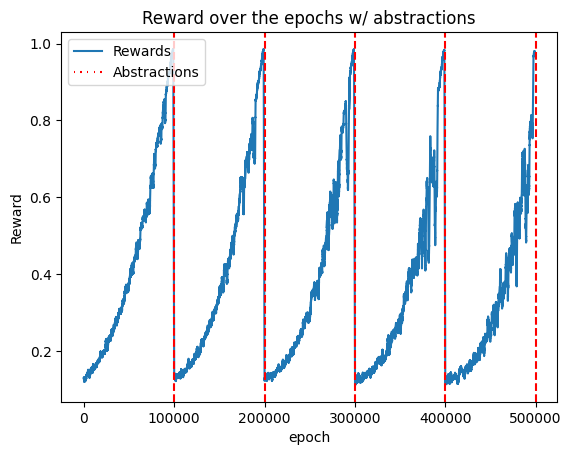

In [ ]:
from matplotlib.legend_handler import HandlerTuple

r = plt.plot(moving_average(rew_list, 1000))

abs = []
for i in range(1, n_abstractions + 1):
  abs.append(plt.axvline(x = i*n_iterations, color = 'r', linestyle='--'))

# Creating custom legend handles
handles = [tuple(r), tuple(abs)]
labels = ['Rewards', 'Abstractions']

plt.title('Reward over the epochs w/ abstractions')
plt.xlabel('epoch')
plt.ylabel('Reward')
plt.legend(handles, labels, handler_map={tuple: HandlerTuple(ndivide=None)})

The first observation that can be made out of this plot is that, everytime we introduce a new level of abstraction, the system is able to converge back to an optimal policy.

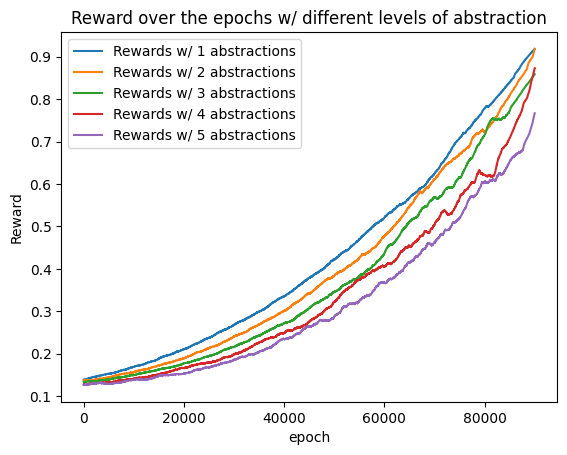

In [ ]:
for i in range(1, n_abstractions+1):
  plt.plot(moving_average(rew_list[(i-1)*n_iterations:(i*n_iterations)-1], 10000), label=f'Rewards w/ {i} abstractions')

plt.title('Reward over the epochs w/ different levels of abstraction')
plt.xlabel('epoch')
plt.ylabel('Reward')
plt.legend()

However, it is worth mentionning that at every increase of the abstraction level complexifies the context and thus, the system reaches its optimal policy slower than before.

Communication should always go back up to 100% correct!

What about utterance length? Does it decrease as it does in humans?

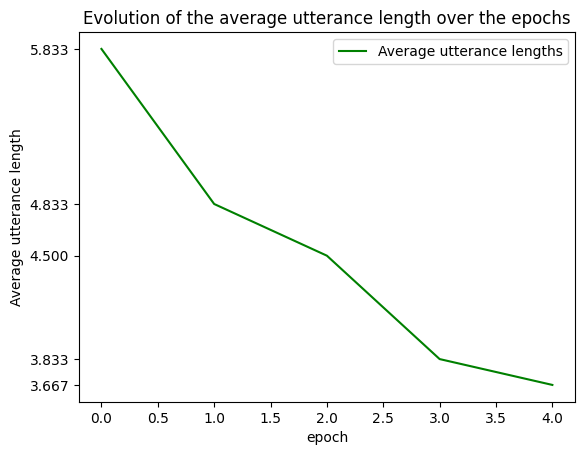

In [ ]:
# Plot the average length of the recipes
plt.plot(utterance_length_list, color='g', label='Average utterance lengths')
plt.title('Evolution of the average utterance length over the epochs')
plt.xlabel('epoch')
plt.ylabel('Average utterance length')
plt.yticks(utterance_length_list)
plt.legend()

After every incrementation of the level of abstraction, the system is able to reduce the length of its utterance. This is a sign of a more efficient communication between our agents.

We can conclude that introducing abstraction into a communication system is a good way to optimize the exchanges between its actors. On a larger scale, it could be very beneficial for system communicating on large sequences.

Hopefully this gave you a simple idea of how Emergent Communication work and why we found that abstractions learning can be used with it to recreate some human tendencies in repeated communication.